In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [88]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-29 00:52:42--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.09s   

2023-10-29 00:52:43 (15.0 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [89]:
df = pd.read_csv('housing.csv')
df = df[df["ocean_proximity"].isin(['<1H OCEAN', 'INLAND'])]
df = df.fillna(0)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [90]:
# split your data in train/val/test sets with 60%/20%/20% distribution

p1 = 0.6  # Training
p2 = 0.2  # Validation
p3 = 0.2  # Test

df_full_train, df_test = train_test_split(df, test_size=p3, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=p2 / (1 - p3), random_state=1)

print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

9411 3138 3138


In [91]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1

In [92]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [93]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### Question 2

In [94]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = round(sqrt(mean_squared_error(y_val, y_pred)), 3)
rmse

0.245

### Question 3

In [95]:
errors = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = round(sqrt(mean_squared_error(y_val, y_pred)), 3)
    
    errors.append((n, rmse))

df_errors = pd.DataFrame(errors, columns=['n_estimators', 'rmse'])
df_errors


,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.234
9,100,0.234


50

### Question 4

In [96]:
errors = []

for d in [10, 15, 20, 25]:

    single_depth_errors = []

    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = sqrt(mean_squared_error(y_val, y_pred))
        
        single_depth_errors.append(rmse)

    errors.append((d, mean(single_depth_errors)))

df_errors = pd.DataFrame(errors, columns=['max_depth', 'rmse'])
df_errors

,max_depth,rmse
0,10,0.245441
1,15,0.235938
2,20,0.235284
3,25,0.234896


10

### Question 5

In [97]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [98]:
pd.DataFrame(data=zip(df_train.columns, rf.feature_importances_), columns=["feature", "importance"]).\
    sort_values(by="importance", ascending=False)

,feature,importance
4,total_bedrooms,0.335668
5,population,0.292473
2,housing_median_age,0.101891
3,total_rooms,0.086176
6,households,0.073806
1,latitude,0.030194
7,median_income,0.026821
8,ocean_proximity,0.016245
0,longitude,0.014953


### Question 6

In [101]:
features = dv.get_feature_names_out()
features = [feature.replace("<", "lt") for feature in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [102]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [103]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [104]:
scores = {}

In [105]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [106]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [107]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [108]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

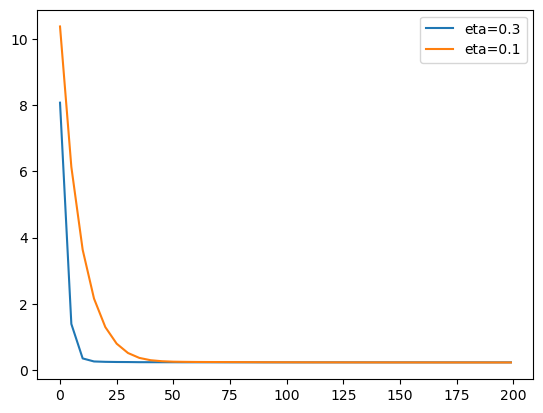

In [113]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta);

plt.legend()

eta=0.3